<a href="https://colab.research.google.com/github/VladimirBlinov/ColabNotebooks/blob/main/spread__regretion_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive # Подключаем гугл-диск
drive.mount('/content/drive')

import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np 
import seaborn as sns 
import math as math
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, median_absolute_error, r2_score
from statsmodels.tsa.stattools import adfuller
import csv


Mounted at /content/drive


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
#создаем файл для вывода данных
with open('/content/drive/MyDrive/Colab Notebooks/Dipl/'+ output_file,'w') as f:
    f.write('X,Y,Mean_X,Mean_Y,Slope,Intercept,Spread_pvalue,Sigma spread,Sigma delta,Total_profit,Total_profit_perc\n') # TRAILING NEWLINE

#создаем файл для памяти
with open('/content/drive/MyDrive/Colab Notebooks/Dipl/mem.csv','w') as m:
    m.write('namex,namey\n') # TRAILING NEWLINE

In [ ]:
#Подготовка данных
input_file='data_spb5.csv'
output_file = 'pairs_spb5_long.csv'

In [ ]:
def adf_test(timeseries):
    '''
    This function perform Dickey-Fuller test
    timeseries: series
    The timeseries to make test

    return: float
    p-value
    '''
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    return dftest[1]

def scale(df):
    return (df - df.mean()) / df.std()

def clear_ticker (name,data):
  ticker_data=data.loc[:,[name]]
  ticker_data.dropna(axis=0, how='any', inplace=True)
  return ticker_data

def clear_pair (namex,namey,data):
  sberdata=data.loc[:,[namex,namey]]
  sberdata.dropna(axis=0, how='any', inplace=True)
  return sberdata

In [ ]:

mem=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dipl/mem.csv', delimiter=',')
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dipl/'+ input_file, delimiter=';')
data.index=pd.to_datetime(data.date, format='%Y-%m-%d %H:%M', errors='ignore' )

data.drop(['date','dataunformated'], axis=1, inplace=True)
data=data.sort_index(ascending=True)
data.dropna(axis=0, how='all', inplace=True)

#оставляем акции, которые стоят менее Х долларов
price_limit=200
data_filter = data[data<price_limit]
data_filter.dropna(axis=0, how='all', inplace=True)
data_filter.dropna(axis=1, how='all', inplace=True)
print(data_filter)
#print(data_filter.info())


                      FLWS     TXG   TWOU     MMM  ...   FTDR   IRBT   JCOM   LASR
date                                               ...                            
2020-09-10 18:05:00    NaN     NaN    NaN     NaN  ...  41.17    NaN  72.59  20.91
2020-09-10 18:10:00    NaN     NaN    NaN     NaN  ...  41.11    NaN  72.77    NaN
2020-09-10 18:15:00    NaN     NaN    NaN     NaN  ...  41.10    NaN  72.54    NaN
2020-09-10 18:20:00    NaN     NaN    NaN     NaN  ...  41.32    NaN  72.77    NaN
2020-09-10 18:25:00    NaN     NaN    NaN     NaN  ...  41.34    NaN  72.78    NaN
...                    ...     ...    ...     ...  ...    ...    ...    ...    ...
2020-11-20 23:30:00  22.42  140.16  34.05  171.97  ...  45.89  78.11  84.56  31.37
2020-11-20 23:35:00  22.42  140.16  34.06  172.46  ...  45.91  78.21  84.66  31.44
2020-11-20 23:40:00  22.48  140.05  34.06  172.47  ...  45.92  78.35  84.62  31.53
2020-11-20 23:45:00  22.47  140.32  34.05  172.78  ...  45.99  78.48  84.69  31.48
2020

In [ ]:
#Подбор пар с корреляцией от 0.7 до 0.98

correl=data_filter.corr() #рассчитываем корреляцию между ценами акций
correl_filter=correl[(correl>0.8)&(correl<0.95)] #из таблицы корреляций отбираем акции, которые коррелируют
#print(correl_filter)
correl_filter.dropna(axis=1, how='all', inplace=True)
correl_filter.dropna(axis=0, how='all', inplace=True)
correl_filter_z=correl_filter.fillna(0) #заменяем NaN на 0 чтобы потом отфильтровать 
#print(correl_filter_z)


#Тест ADF
tickers_adf = correl_filter.columns.tolist() #создаем список названий акций для теста ADF
tickers=[] #создаем список названий акций для регрессии
for ticker in tickers_adf:
  ticker_data = clear_ticker (ticker,data_filter) #убираем пропуски
  if len(ticker_data[ticker]) > 1000:
    ticker_p=adf_test(ticker_data[ticker]) #Тест ADF
    if ticker_p > 0.05:  # если не стационарный ряд, то добавляем в список для регрессии
      tickers.append(ticker)

print(tickers)

pairs={} #словарь для хранения пар
for ticker in tickers: #перебираем список названий акций
  tickers_correl=correl_filter_z[correl_filter_z[ticker]!=0][ticker].index.tolist() #из таблицы корреляций отбираем акции, которые коррелируют с текущей акцией
  pairs[ticker]=tickers_correl
  #print(len(tickers_correl), 'акций коррелирут с ', ticker)

print(pairs)
print(len(pairs))


['FLWS', 'TXG', 'TWOU', 'MMM', 'JOBS', 'EGHT', 'AAON', 'AIR', 'ACAD', 'ACMR', 'ACM', 'AGCO', 'ALE', 'AMCX', 'AME', 'AMN', 'ANGI', 'ANIP', 'ASGN', 'T', 'ATNI', 'AAN', 'ABBV', 'ABT', 'XLRN', 'ATVI', 'AYI', 'ADUS', 'ASIX', 'AAP', 'AEIS', 'AMD', 'AERI', 'AVAV', 'AJRD', 'AMG', 'AFL', 'A', 'AGIO', 'AKAM', 'ALG', 'ALRM', 'ALK', 'AIN', 'ALB', 'ARE', 'ALXN', 'ALLK', 'ALGT', 'ALLE', 'ADS', 'LNT', 'ALSN', 'ALLO', 'MDRX', 'ALNY', 'ALTR', 'AYX', 'ATUS', 'MO', 'ACH', 'AEE', 'CRMT', 'AAL', 'AXP', 'AFG', 'AIG', 'APEI', 'AWR', 'AWK', 'AMWD', 'AMP', 'ABC', 'APH', 'ADI', 'PLAN', 'ANAB', 'BUD', 'ANIK', 'ATEX', 'AON', 'APA', 'AIV', 'APPF', 'APPN', 'APLE', 'AAPL', 'AIT', 'AMAT', 'APLT', 'ATR', 'APTV', 'ARMK', 'ADM', 'ARNC', 'ARCT', 'ARNA', 'AWI', 'ARW', 'ARWR', 'AJG', 'ARVN', 'ABG', 'ASH', 'AZPN', 'AIZ', 'ATRO', 'ATRA', 'ATKR', 'ATRC', 'AN', 'ALV', 'ADP', 'AVLR', 'AVB', 'AVNS', 'AVY', 'AVNT', 'AXGN', 'AAXN', 'AX', 'AXSM', 'BJRI', 'BMCH', 'BOKF', 'BMI', 'BIDU', 'BKR', 'BCPC', 'BLL', 'BAND', 'BAC', 'BOH', 'BZ

In [ ]:
def spread_calc (namex,namey,sberdata):
  X=sberdata[[namex]].values
  y=sberdata[namey].values

  if len(X)>1000 and len(y)>1000:
    #spread
    slr = LinearRegression()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=0)
    slr.fit(X_train, y_train)

    sberdata['spread']=sberdata[namey]-slr.coef_[0]*sberdata[namex]-slr.intercept_
    spread_p=adf_test(sberdata['spread'], 'spread',2)

    if spread_p<=0.04:
      sberdata['ma'] = sberdata['spread'].rolling(window=10).mean()
      sberdata['delta']=sberdata['spread']-sberdata['ma']
      sberdata['scale_delta']=scale(sberdata['delta'])
      sberdata['spread_perc']=sberdata['spread']/sberdata[namey]*100
      spread_sq=sberdata['spread'].std()
      delta_sq=sberdata['delta'].std()

  #----------------------------------------------------------------------
      #тест на истории
      sberdata['enter_x']=0
      sberdata['enter_y']=0
      sberdata['exit_x']=0
      sberdata['exit_y']=0
      sberdata['profit_x']=0
      sberdata['profit_y']=0
      sberdata['profit']=0
      sberdata['tradetime']=0
      pos=0
      min_lim=-1.9
      max_lim=1.9
      count_tr=0

      for x in range(10,sberdata[namex].size):
        ds=sberdata.loc[sberdata.index[x],'scale_delta']
        price_x=sberdata.loc[sberdata.index[x],[namex]][0]
        price_y=sberdata.loc[sberdata.index[x],[namey]][0]

        #вход в позицию
        if pos==0:
          if ds>= max_lim:
            pos=1
            cache=x
            enter_x=pos*price_x*slr.coef_[0]
            enter_y=pos*price_y*-1
            sberdata.loc[sberdata.index[x],['enter_x']]=enter_x
            sberdata.loc[sberdata.index[x],['enter_y']]=enter_y

        if pos==0:
          if min_lim >= ds :
            pos=-1
            cache=x
            enter_x=pos*price_x*slr.coef_[0]
            enter_y=pos*price_y*-1
            sberdata.loc[sberdata.index[x],['enter_x']]=enter_x
            sberdata.loc[sberdata.index[x],['enter_y']]=enter_y
              
        #выход из позиции
        if pos==1 and ds<=0:
          exit_x=pos*price_x*slr.coef_[0]
          exit_y=pos*price_y*-1
          enter_x=sberdata.loc[sberdata.index[cache],['enter_x']][0]
          enter_y=sberdata.loc[sberdata.index[cache],['enter_y']][0]
          sberdata.loc[sberdata.index[cache],['exit_x']]=exit_x
          sberdata.loc[sberdata.index[cache],['exit_y']]=exit_y
          profit_x=exit_x-enter_x
          profit_y=exit_y-enter_y
          fee=(math.fabs(enter_x) + math.fabs(exit_x) + math.fabs(enter_y) + math.fabs(exit_y))*0.06/100
          profit=profit_x+profit_y-fee
          sberdata.loc[sberdata.index[cache],['profit_x']]=profit_x
          sberdata.loc[sberdata.index[cache],['profit_y']]=profit_y
          sberdata.loc[sberdata.index[cache],['profit']]=profit
          sberdata.loc[sberdata.index[cache],['tradetime']]=x-cache
          cache=0
          pos=0
          count_tr+=1

        if pos==-1 and ds>=0:
          exit_x=pos*price_x*slr.coef_[0]
          exit_y=pos*price_y*-1
          enter_x=sberdata.loc[sberdata.index[cache],['enter_x']][0]
          enter_y=sberdata.loc[sberdata.index[cache],['enter_y']][0]
          sberdata.loc[sberdata.index[cache],['exit_x']]=exit_x
          sberdata.loc[sberdata.index[cache],['exit_y']]=exit_y
          profit_x=exit_x-enter_x
          profit_y=exit_y-enter_y
          fee=(math.fabs(enter_x) + math.fabs(exit_x) + math.fabs(enter_y) + math.fabs(exit_y))*0.05/100
          profit=profit_x+profit_y-fee
          sberdata.loc[sberdata.index[cache],['profit_x']]=profit_x
          sberdata.loc[sberdata.index[cache],['profit_y']]=profit_y
          sberdata.loc[sberdata.index[cache],['profit']]=profit
          sberdata.loc[sberdata.index[cache],['tradetime']]=x-cache
          cache=0
          pos=0
          count_tr+=1
      
      #анализ результата теста истории
      total_profit=sberdata['profit'].sum()
      total_profit_perc = (total_profit/(sberdata[namey].mean()+slr.coef_[0]*sberdata[namex].mean()))*100
            
      sberdata['total_profit_cum']=0
      for i in range(0,len(sberdata['profit'])):
        sberdata.loc[sberdata.index[i],['total_profit_cum']]=sberdata.loc[sberdata.index[i-1],['total_profit_cum']][0]+sberdata.loc[sberdata.index[i],['profit']][0]
      cumsum_min=sberdata['total_profit_cum'].min()

      tradetime_max = sberdata['tradetime'].max()
      tradetime_mean = sberdata['tradetime'].mean()
      minprofit=((sberdata['profit']/(sberdata[namey].mean()+slr.coef_[0]*sberdata[namex].mean()))*100).min()
      negativeprofit=sberdata[sberdata['profit']<0]['profit'].count()
      positiveprofit=sberdata[sberdata['profit']>0]['profit'].count()
      profitfactor=positiveprofit/count_tr

  #-------------------------------------------------------------------
      #вывод результата
      if total_profit_perc>5 and minprofit>=-0.5 and profitfactor >= 0.8 :

        with open('/content/drive/MyDrive/Colab Notebooks/Dipl/'+ output_file,'a',newline='') as f:
          writer=csv.writer(f)
          writer.writerow([namex,namey,sberdata[namex].mean(),sberdata[namey].mean(),round(slr.coef_[0],4),round(slr.intercept_,4),round(spread_p,4),round(spread_sq,4),round(delta_sq,4),total_profit,total_profit_perc])
          
        path='/content/drive/MyDrive/Colab Notebooks/Dipl/data_spb5/spb_'+namex+namey+'.jpeg'

        print('\n')
        print('Spread p.value: {:.4f}'. format(spread_p))
        print('\n')

        print('spread mean: {:.4f}'. format(sberdata['spread'].mean()))
        print('spread std: {:.4f}'.format(spread_sq))
        print('delta std: {:.4f}'.format(delta_sq))
        print('price_mean',namex,':',sberdata[namex].mean())
        print('price_mean',namey,':',sberdata[namey].mean())

        print('Slope: {:.4f}'.format(slr.coef_[0]))
        print('Intercept: {:.2f}'.format(slr.intercept_))
        print('\n')

        print('Test profit: ', total_profit)
        print('Total profit %: {:.2f}'.format(total_profit_perc))
        print('total trades: ',count_tr)
        print("positive trades: ", positiveprofit)
        print('profit factor :',profitfactor)
        print('mean trade time:  {:.1f}'.format(tradetime_mean))
        print('max trade time:  {:.1f}'.format(tradetime_max))

        print('\n')

        '''
        y_train_pred = slr.predict(X_train)
        y_test_pred = slr.predict(X_test)
        print('MSE train: {:.3f}, test: {:.3f}'.format(
                            mean_squared_error(y_train, y_train_pred),
                            mean_squared_error(y_test, y_test_pred)))
        print('R^2 train: {:.3f}, test: {:.3f}'.format(
                            r2_score(y_train, y_train_pred),
                            r2_score(y_test, y_test_pred)))
        print('\n')

        plt.figure(figsize=(10,4))
        plt.subplot(121)
        sns.regplot(x=namex, y=namey, data=sberdata)

        plt.subplot(122)
        plt.scatter(y_train_pred,  y_train_pred - y_train, c='blue', marker='o', label='Training data')
        plt.scatter(y_test_pred,  y_test_pred - y_test, c='lightgreen', marker='s', label='Test data')
        plt.xlabel('Predicted values')
        plt.ylabel('Residuals')
        plt.legend(loc='upper left')
        plt.show()

        '''
        #--------------------------------------------
        plt.figure(figsize=(15,30))
        plt.subplot(511)
        plt.plot(sberdata['spread'], label='Spread')
        plt.plot(sberdata['ma'], label='ma')
        plt.plot(sberdata.index,[0 for i in range(len(sberdata.index))])
        plt.legend(loc='upper left')
        plt.title((namex,namey))

        plt.subplot(512)
        plt.plot(scale(sberdata['delta']), label='scaled delta')
        plt.plot(sberdata.index,[2 for i in range(len(sberdata.index))])
        plt.plot(sberdata.index,[-2 for i in range(len(sberdata.index))])
        plt.legend(loc='upper left')

        plt.subplot(513)
        plt.plot((sberdata['profit']/(sberdata[namey].mean()+slr.coef_[0]*sberdata[namex].mean()))*100, label='profit %')
        plt.legend(loc='upper left')

        plt.subplot(514)
        plt.plot((sberdata['total_profit_cum']/(sberdata[namey].mean()+slr.coef_[0]*sberdata[namex].mean()))*100, label='profit_cumsum %')
        plt.legend(loc='upper left')

        plt.subplot(515)
        plt.plot(sberdata['tradetime'], label= 'tradetime')
        plt.legend(loc='upper left')

        plt.savefig (path)
        plt.show()


Выходные данные были обрезаны до нескольких последних строк (5000).
progress correl:  162  of  403
VC HLT
progress correl:  163  of  403
VC HON
progress correl:  164  of  403
VC TWNK
progress correl:  165  of  403
VC HLI
progress correl:  166  of  403
VC HWM
progress correl:  167  of  403
VC HBAN
progress correl:  168  of  403
VC HII
progress correl:  169  of  403
VC H
progress correl:  170  of  403
VC IAC
progress correl:  171  of  403
VC ICFI
progress correl:  172  of  403
VC IDA
progress correl:  173  of  403
VC INFO
progress correl:  174  of  403
VC IIVI
progress correl:  175  of  403
VC IPGP
progress correl:  176  of  403
VC ITT
progress correl:  177  of  403
VC INDB
progress correl:  178  of  403
VC IR
progress correl:  179  of  403
VC NGVT
progress correl:  180  of  403
VC IOSP
progress correl:  181  of  403
VC IPHI
progress correl:  182  of  403
VC NSIT
progress correl:  183  of  403
VC NSP
progress correl:  184  of  403
VC NTLA
progress correl:  185  of  403
VC IPAR
progress c

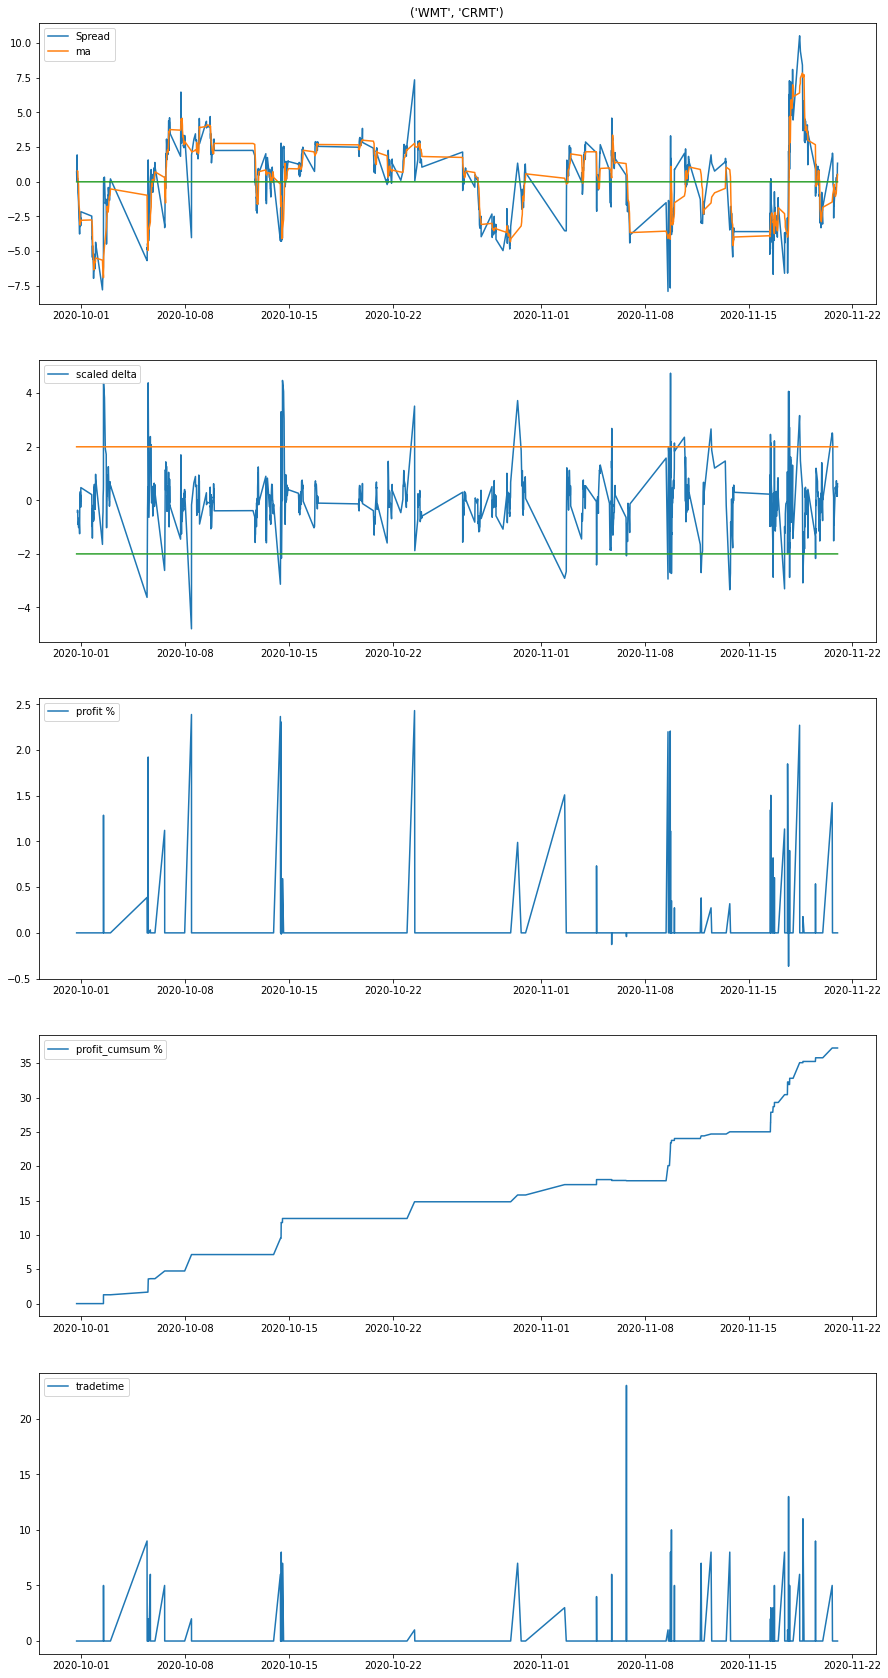

progress correl:  21  of  365
WMT AXP
progress correl:  22  of  365
WMT AFG
progress correl:  23  of  365
WMT AMP
progress correl:  24  of  365
WMT APH
progress correl:  25  of  365
WMT ADI
progress correl:  26  of  365
WMT BUD
progress correl:  27  of  365
WMT APPN
progress correl:  28  of  365
WMT APLE
progress correl:  29  of  365
WMT AIT
progress correl:  30  of  365
WMT AMAT
progress correl:  31  of  365
WMT ATR
progress correl:  32  of  365
WMT APTV
progress correl:  33  of  365
WMT ARMK
progress correl:  34  of  365
WMT ARNC
progress correl:  35  of  365
WMT ARW
progress correl:  36  of  365
WMT AJG
progress correl:  37  of  365
WMT ASH
progress correl:  38  of  365
WMT ATRA
progress correl:  39  of  365
WMT ATKR
progress correl:  40  of  365
WMT ALV
progress correl:  41  of  365
WMT AXGN
progress correl:  42  of  365
WMT AAXN
progress correl:  43  of  365
WMT BJRI
progress correl:  44  of  365
WMT BDC
progress correl:  45  of  365
WMT BERY
progress correl:  46  of  365
WMT BRC


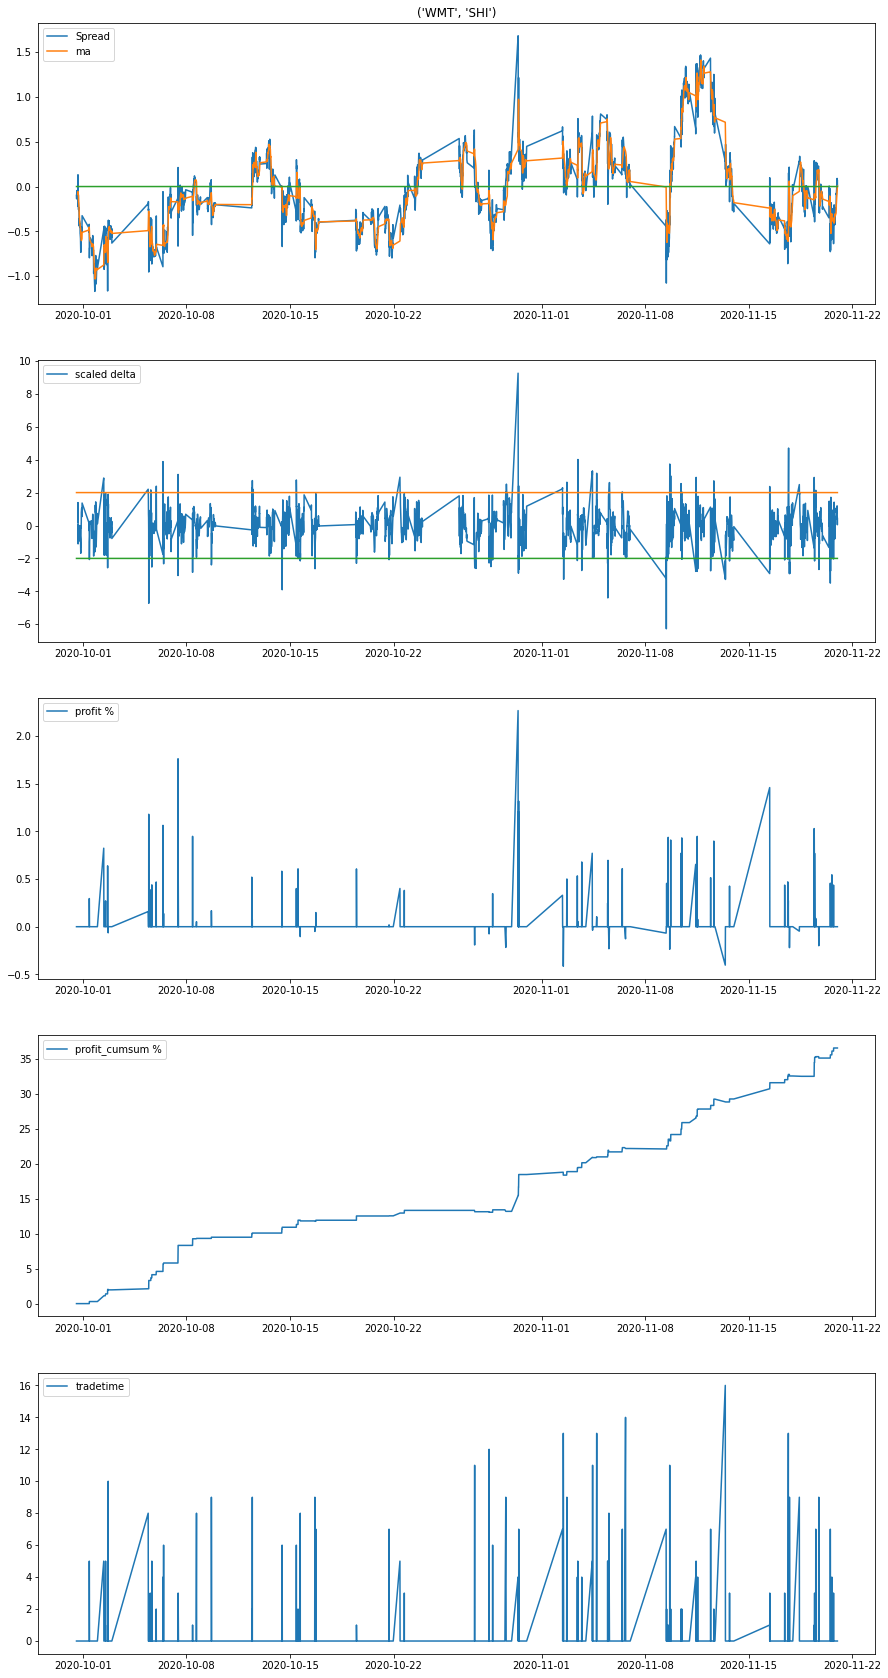

progress correl:  290  of  365
WMT SON
progress correl:  291  of  365
WMT LUV
progress correl:  292  of  365
WMT SPB@US
progress correl:  293  of  365
WMT SR
progress correl:  294  of  365
WMT SPR
progress correl:  295  of  365
WMT SXI
progress correl:  296  of  365
WMT SWK
progress correl:  297  of  365
WMT SBUX
progress correl:  298  of  365
WMT STT
progress correl:  299  of  365
WMT STLD
progress correl:  300  of  365
WMT SYNH
progress correl:  301  of  365
WMT SYY
progress correl:  302  of  365
WMT TMUS
progress correl:  303  of  365
WMT TCRR
progress correl:  304  of  365
WMT TEL
progress correl:  305  of  365
WMT TGNA
progress correl:  306  of  365
WMT KO
progress correl:  307  of  365
WMT TTMI
progress correl:  308  of  365
WMT TSM
progress correl:  309  of  365
WMT TER
progress correl:  310  of  365
WMT TTEK
progress correl:  311  of  365
WMT TXN
progress correl:  312  of  365
WMT TXT
progress correl:  313  of  365
WMT BCO
progress correl:  314  of  365
WMT CHEF
progress correl

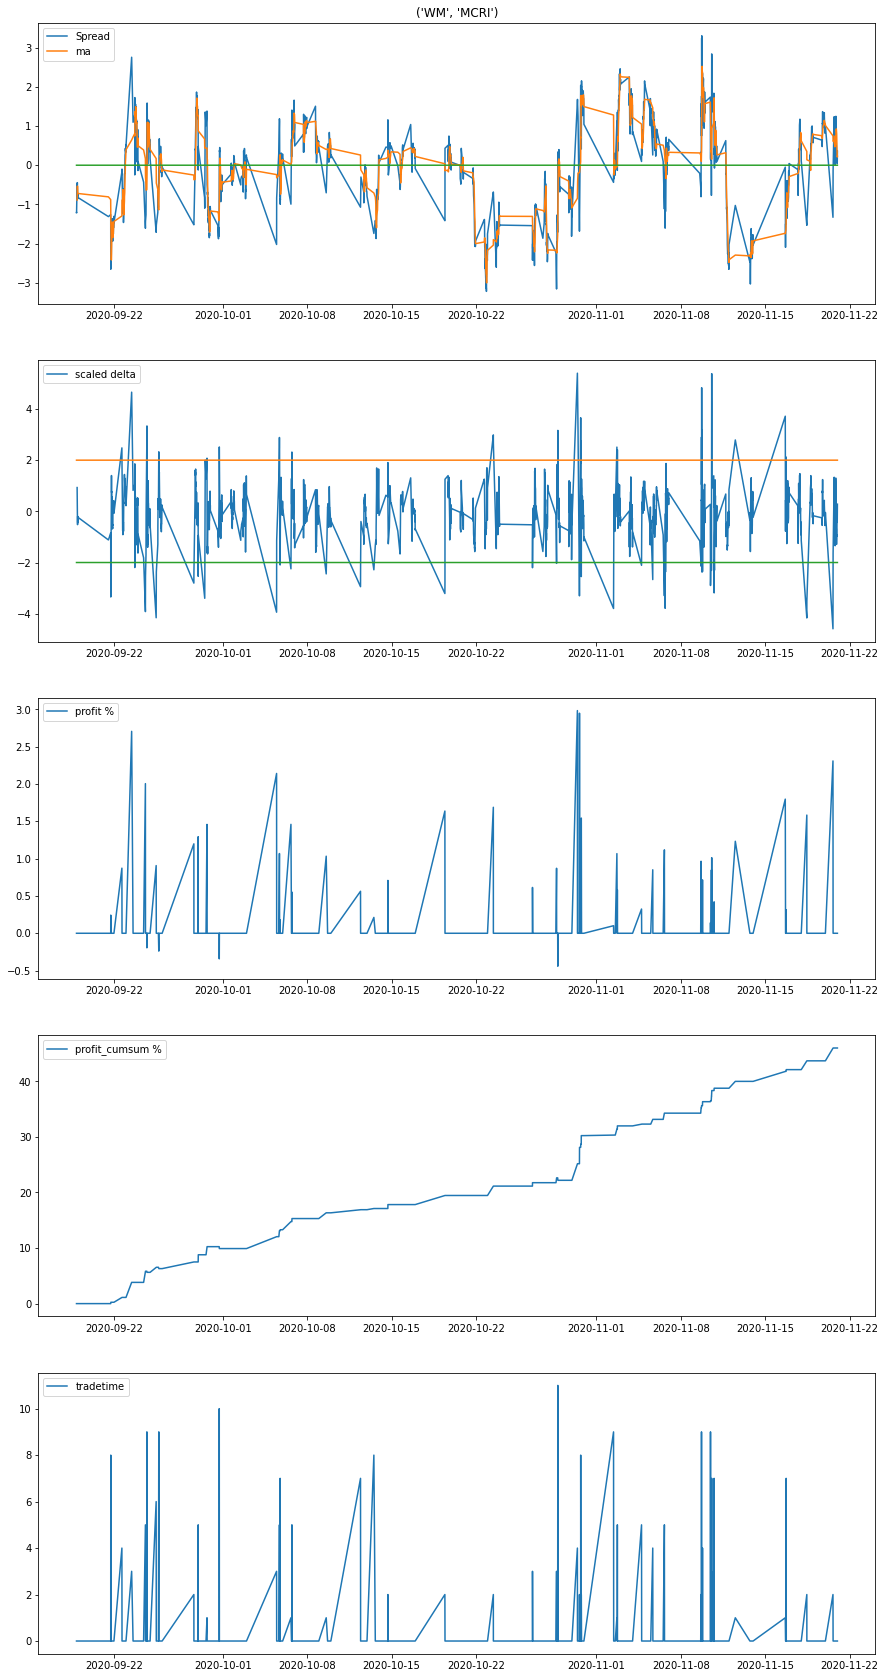

progress correl:  127  of  230
WM MNST
progress correl:  128  of  230
WM MS
progress correl:  129  of  230
WM MYGN
progress correl:  130  of  230
WM NTUS
progress correl:  131  of  230
WM NAVI
progress correl:  132  of  230
WM NP
progress correl:  133  of  230
WM NWL
progress correl:  134  of  230
WM NWSA
progress correl:  135  of  230
WM NWS
progress correl:  136  of  230
WM NTRS
progress correl:  137  of  230
WM OSIS
progress correl:  138  of  230
WM OXY
progress correl:  139  of  230
WM OMC
progress correl:  140  of  230
WM ONTO
progress correl:  141  of  230
WM OFIX
progress correl:  142  of  230
WM PTC
progress correl:  143  of  230
WM PAGS
progress correl:  144  of  230
WM PFGC
progress correl:  145  of  230
WM PRSP
progress correl:  146  of  230
WM PLXS
progress correl:  147  of  230
WM PRI
progress correl:  148  of  230
WM PFG
progress correl:  149  of  230
WM PRU
progress correl:  150  of  230
WM QTWO
progress correl:  151  of  230
WM QCOM
progress correl:  152  of  230
WM QRV

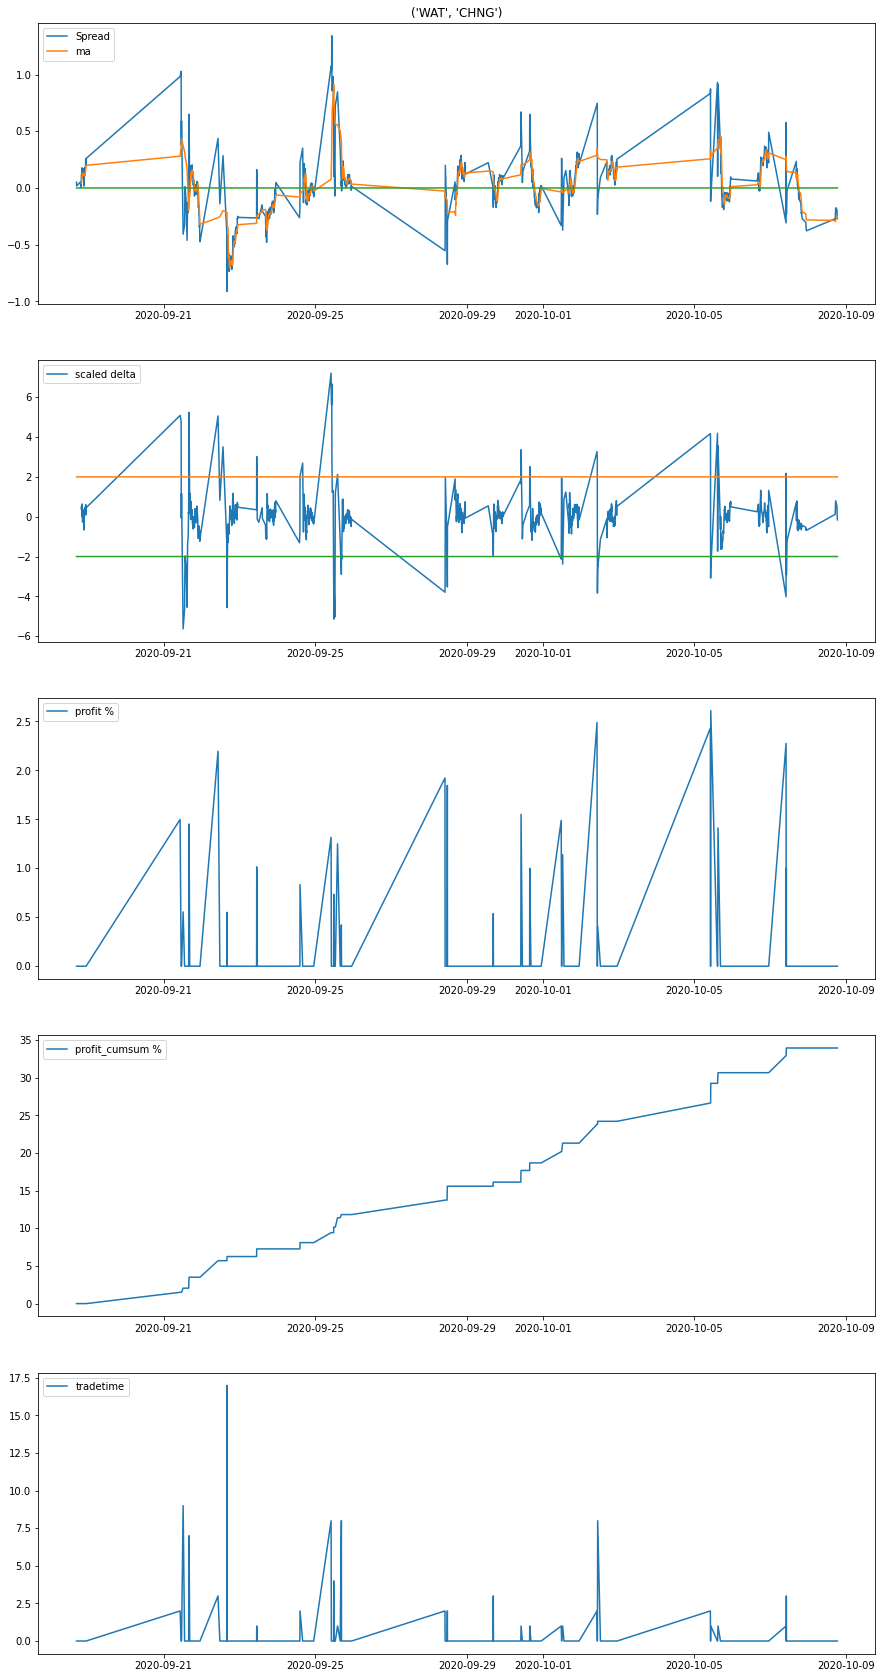

progress correl:  75  of  368
WAT GTLS
progress correl:  76  of  368
WAT CCXI
progress correl:  77  of  368
WAT CB
progress correl:  78  of  368
WAT CI
progress correl:  79  of  368
WAT C
progress correl:  80  of  368
WAT CFG
progress correl:  81  of  368
WAT CLH
progress correl:  82  of  368
WAT CLF
progress correl:  83  of  368
WAT CTSH
progress correl:  84  of  368
WAT CMA
progress correl:  85  of  368
WAT CBSH
progress correl:  86  of  368
WAT CVLT
progress correl:  87  of  368
WAT CMP
progress correl:  88  of  368
WAT CTB
progress correl:  89  of  368
WAT CPRT
progress correl:  90  of  368
WAT CRVL
progress correl:  91  of  368
WAT CSOD
progress correl:  92  of  368
WAT GLW
progress correl:  93  of  368
WAT CTVA
progress correl:  94  of  368
WAT CREE
progress correl:  95  of  368
WAT CCK
progress correl:  96  of  368
WAT DXC
progress correl:  97  of  368
WAT DAR
progress correl:  98  of  368
WAT DAL
progress correl:  99  of  368
WAT DLX
progress correl:  100  of  368
WAT DVN
progr

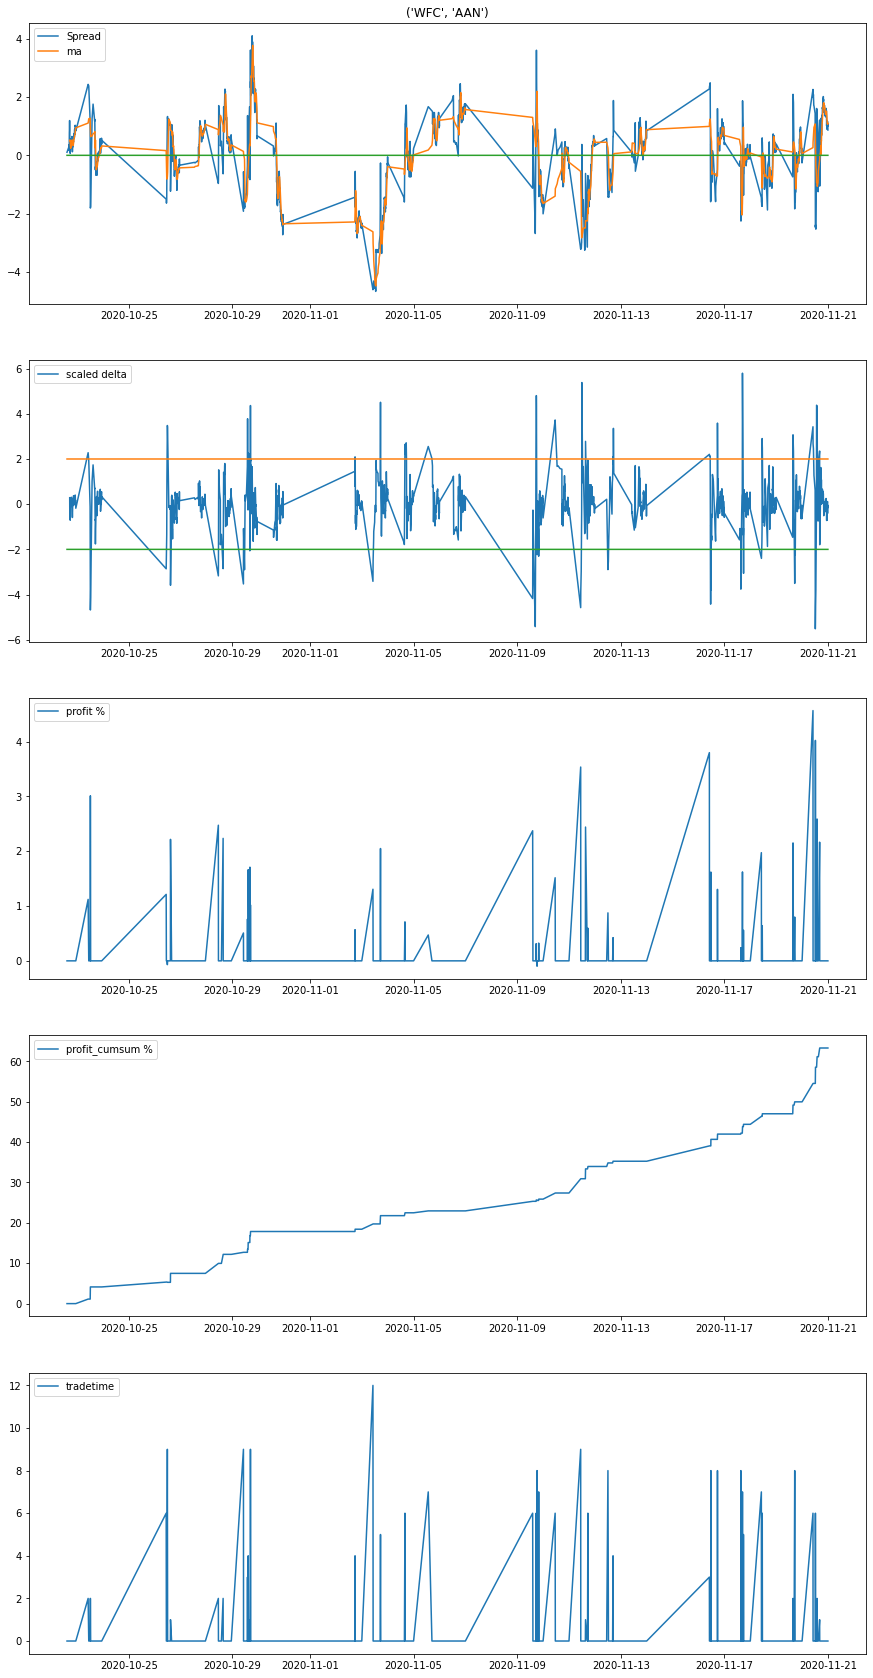

Выходные данные были обрезаны до нескольких последних строк (5000).
WWD DFS
progress correl:  100  of  421
WWD DLB
progress correl:  101  of  421
WWD DG
progress correl:  102  of  421
WWD DCI
progress correl:  103  of  421
WWD DOV
progress correl:  104  of  421
WWD DOW
progress correl:  105  of  421
WWD DD
progress correl:  106  of  421
WWD EOG
progress correl:  107  of  421
WWD ESE
progress correl:  108  of  421
WWD EWBC
progress correl:  109  of  421
WWD EMN
progress correl:  110  of  421
WWD ETN
progress correl:  111  of  421
WWD EPC
progress correl:  112  of  421
WWD EIX
progress correl:  113  of  421
WWD WIRE
progress correl:  114  of  421
WWD ENS
progress correl:  115  of  421
WWD EXPE
progress correl:  116  of  421
WWD EXPO
progress correl:  117  of  421
WWD XOM
progress correl:  118  of  421
WWD FFIV
progress correl:  119  of  421
WWD FITB
progress correl:  120  of  421
WWD FISV
progress correl:  121  of  421
WWD FIVE
progress correl:  122  of  421
WWD FLS
progress correl:  123

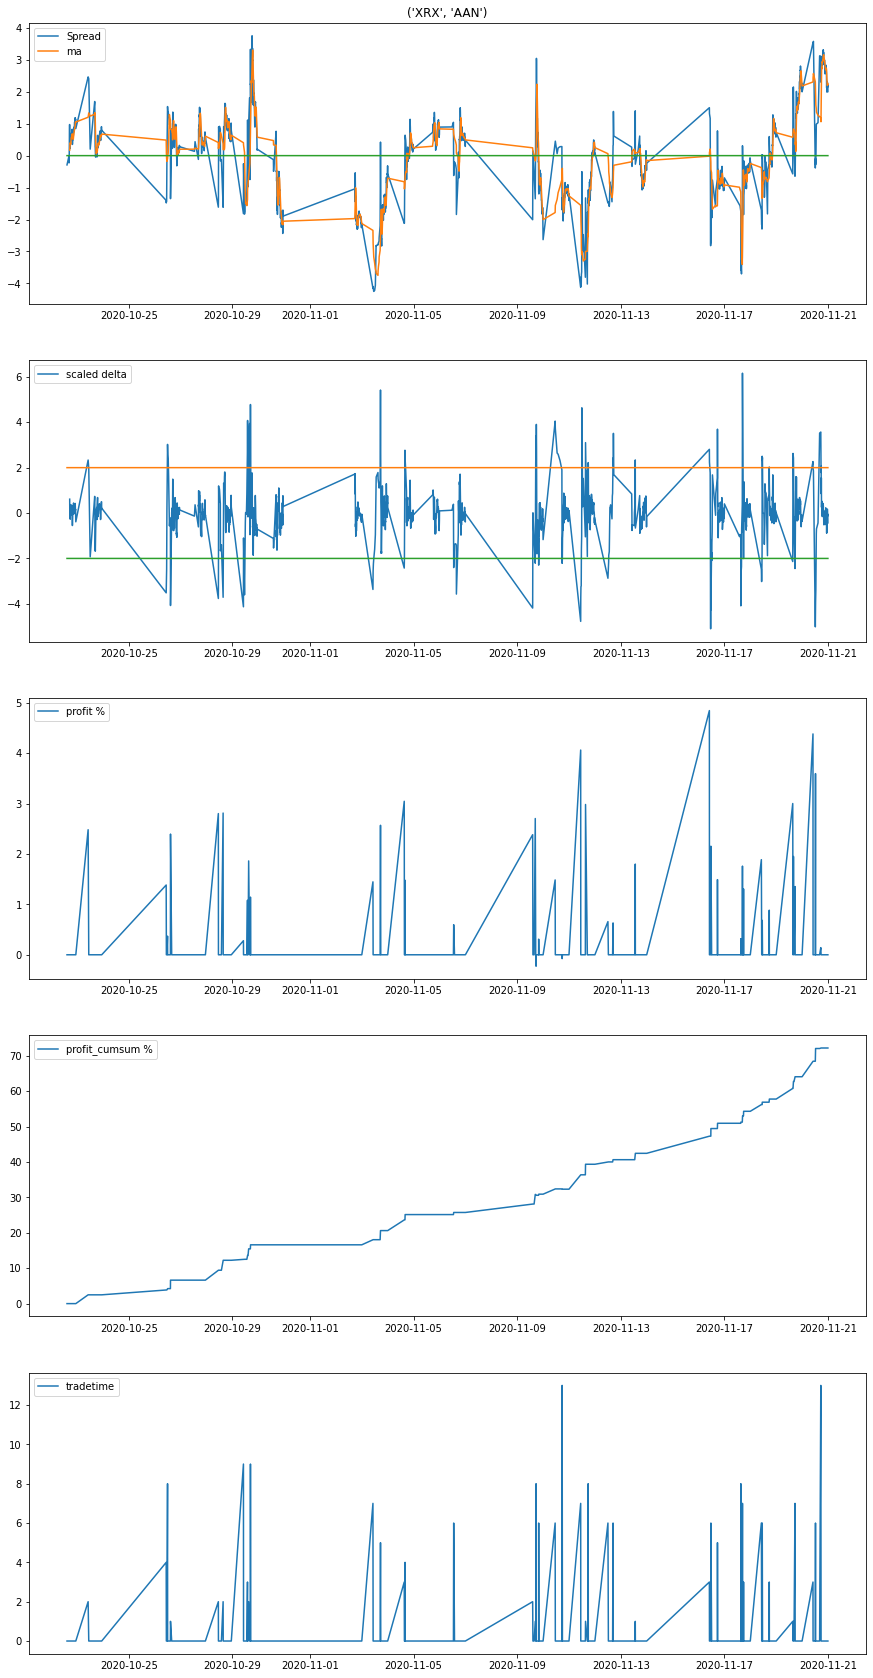

Выходные данные были обрезаны до нескольких последних строк (5000).
progress correl:  37  of  191
YEXT CSWI
progress correl:  38  of  191
YEXT CDNS
progress correl:  39  of  191
YEXT CDNA
progress correl:  40  of  191
YEXT CARR
progress correl:  41  of  191
YEXT CVNA
progress correl:  42  of  191
YEXT CTLT
progress correl:  43  of  191
YEXT CAT
progress correl:  44  of  191
YEXT CNC
progress correl:  45  of  191
YEXT CNP
progress correl:  46  of  191
YEXT GTLS
progress correl:  47  of  191
YEXT NET
progress correl:  48  of  191
YEXT CGNX
progress correl:  49  of  191
YEXT CTSH
progress correl:  50  of  191
YEXT COHR
progress correl:  51  of  191
YEXT CL
progress correl:  52  of  191
YEXT CPRT
progress correl:  53  of  191
YEXT CSOD
progress correl:  54  of  191
YEXT CTVA
progress correl:  55  of  191
YEXT CROX
progress correl:  56  of  191
YEXT CCK
progress correl:  57  of  191
YEXT DAR
progress correl:  58  of  191
YEXT DCPH
progress correl:  59  of  191
YEXT DDS
progress correl:  60 

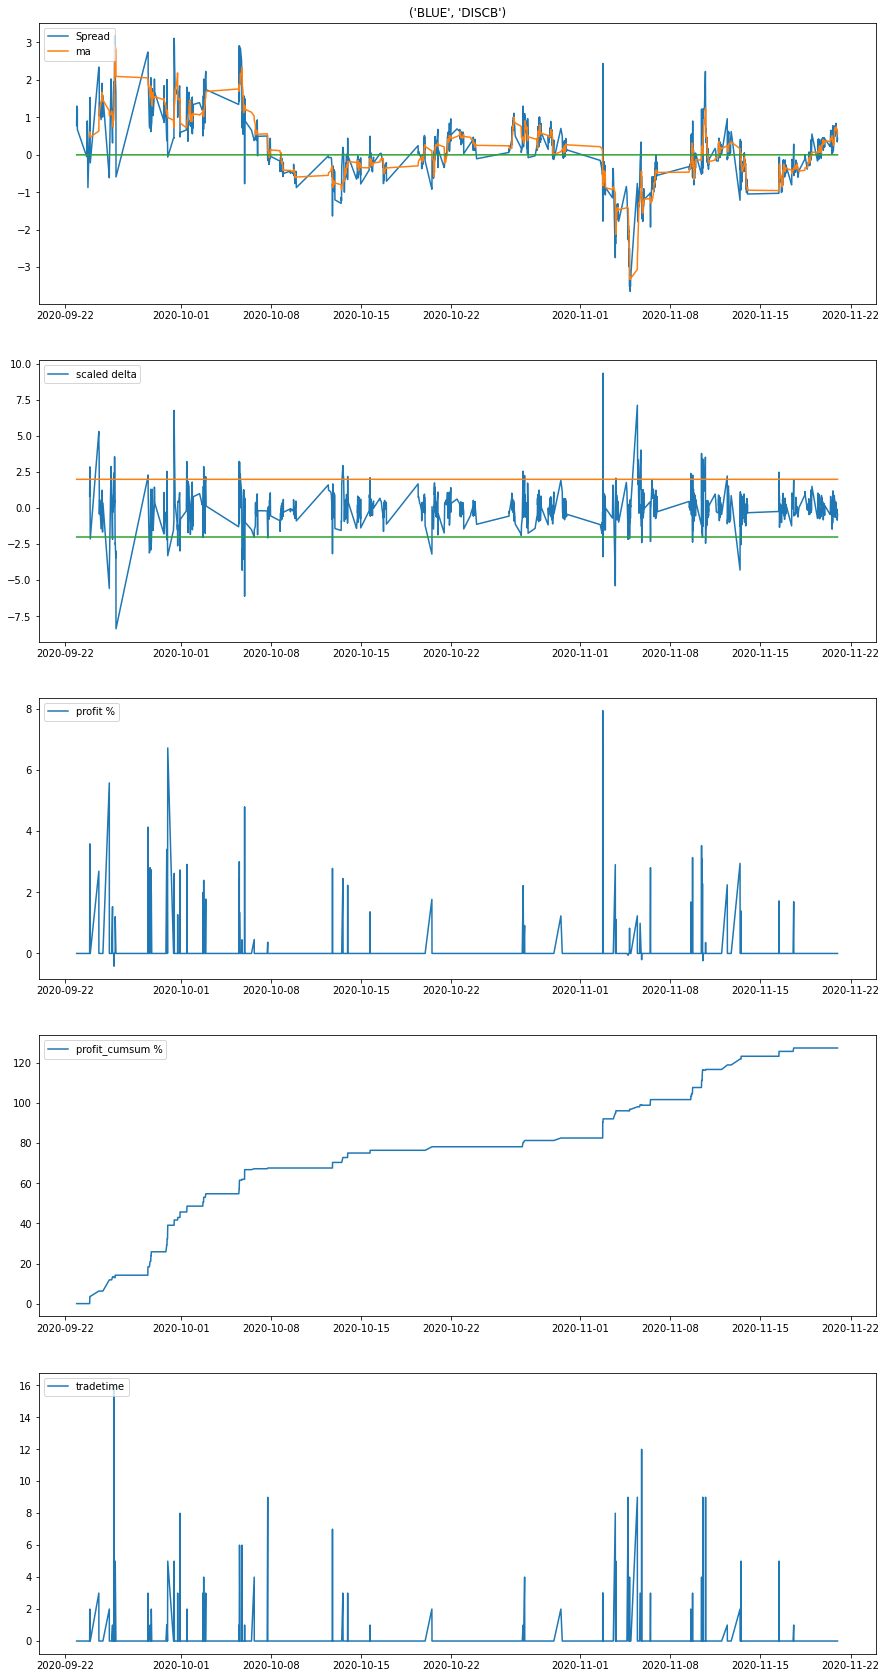

progress correl:  3  of  9
BLUE RDY
progress correl:  4  of  9
BLUE EBS
progress correl:  5  of  9
BLUE EXEL
progress correl:  6  of  9
BLUE GBT
progress correl:  7  of  9
BLUE HBI
progress correl:  8  of  9
BLUE LRN
progress correl:  9  of  9
BLUE PETQ
progress:  1143  of  1149
progress correl:  1  of  41
EBAY FLWS
progress correl:  2  of  41
EBAY AKAM
progress correl:  3  of  41
EBAY ALLO
progress correl:  4  of  41
EBAY APLT
progress correl:  5  of  41
EBAY BAND
progress correl:  6  of  41
EBAY BYND
progress correl:  7  of  41
EBAY BILL
progress correl:  8  of  41
EBAY CHGG
progress correl:  9  of  41
EBAY CHD
progress correl:  10  of  41
EBAY CTXS
progress correl:  11  of  41
EBAY COLM
progress correl:  12  of  41
EBAY CAG
progress correl:  13  of  41
EBAY DDOG
progress correl:  14  of  41
EBAY DLR
progress correl:  15  of  41
EBAY DBX
progress correl:  16  of  41
EBAY DT
progress correl:  17  of  41
EBAY EA
progress correl:  18  of  41
EBAY ECPG
progress correl:  19  of  41
EBAY E

In [ ]:
mem=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Dipl/mem.csv', delimiter=',')
cnt=0
cnt_mem=0
print(mem)
print(mem['namex'].size)

for ticker in pairs: #перебираем акции, с которыми есть корреляция
  cnt+=1
  print('progress: ', cnt,' of ', len(pairs))
  cnt1=0
  for ticker_cor in pairs[ticker]:
    skip=0
    cnt1+=1
    print('progress correl: ', cnt1,' of ', len(pairs[ticker]))
    print(ticker,ticker_cor)

    if cnt_mem < mem['namex'].size and mem['namex'].size!=0 :
      skip=1

    cnt_mem+=1

    if skip == 0:
      namex,namey=ticker,ticker_cor
      sberdata = clear_pair(namex,namey,data_filter)

      with open('/content/drive/MyDrive/Colab Notebooks/Dipl/mem.csv','a',newline='') as m:
            writer=csv.writer(m)
            writer.writerow([namex,namey])

      spread_calc (namex,namey,sberdata)

print('\n')  
print('Done')